In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
sys.path.insert(0,"/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.misc import *

In [3]:
data_path = "/home/rzhu/data_access/l2l_data/logs/LTL-NWN-volterra-SA/run-no-2023-04-01-194347/"

In [4]:
fnames = os.listdir(data_path +"per_gen_trajectories")
fnames.sort()
n_gens = len(fnames)

In [5]:
results = []
for fn in fnames:
    fileName = os.path.join(data_path, "per_gen_trajectories", fn)
    temp = pkl_load(fileName)
    gen_out = torch.tensor([r[1][0] for r in temp.current_results])
    results.append(gen_out)

n_ins = len(gen_out)
results = torch.stack(results)

In [6]:
hyper_keys = temp.individual.__dict__["params"].keys()
hyper_dict = {}

for key in hyper_keys:
    hyper_dict[key] = torch.zeros(n_gens, n_ins)
    for i in range(n_gens):
        for j in range(n_ins):
            hyper_dict[key][i][j] = temp.individuals[i][j].__dict__["params"][key]

Text(0, 0.5, 'Pre initialization time (s)')

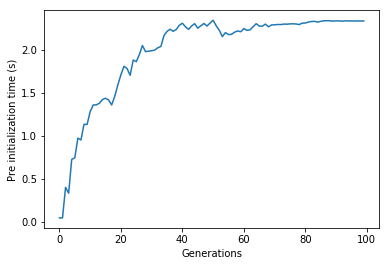

In [7]:
# error_shade(hyper_dict["individual.init_time"].mean(axis = 1)*10, 
#             hyper_dict["individual.init_time"].std(axis = 1)*10 / np.sqrt(10))
plt.plot(hyper_dict["individual.init_time"].mean(axis = 1) * 10,)
# plt.xticks([0,5,10,15,20])
plt.xlabel("Generations")

plt.ylabel("Pre initialization time (s)")

In [8]:
gen    = n_gens-1
Gnets  = torch.zeros(n_ins, 3000)
inits  = torch.zeros(n_ins, dtype = int)
r2     = torch.zeros(n_ins)
testid = torch.zeros(n_ins, 5)
# Ws     = torch.zeros(n_ins)
# bs     = torch.zeros(n_ins)

for i in range(n_ins):
    temp = pkl_load(data_path+f"results/gen_{gen:04d}_ind_{i:04d}.pkl")
    Gnets[i] = temp["netG"]
    inits[i] = int(temp["params"]["init_time"].item() * 10000)
    r2[i]  = temp["tests"][:,1].mean()
    testid[i] = temp["tests"][:,0]


In [9]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

from tqdm import tqdm

In [10]:
def prepare_network(index = 0):
    snn_data_path = "/home/rzhu/data_access/l2l_data/snn_data_new/"
    adj = torch.tensor(pkl_load(snn_data_path + "con0.pkl")["adj_matrix"])
    net = NWN(adj, "sydney")x

    net.params["Ron"]       = 1e4
    net.params["grow"]      = 5
    net.params["decay"]     = 10
    net.params["precision"] = True
    return net

In [11]:
volterra_path = "/home/rzhu/data_access/l2l_data/volterra_data/"
lambda_dict   = pkl_load(volterra_path+"lambda_data.pkl")

In [12]:
X,Y        = pkl_load(volterra_path+f"pair_0.pkl")
steps      = len(X)
n_in       = 1
n_out      = 64
# torch.manual_seed(0)
readout    = torch.zeros(steps, n_out)

lambda_dict          = pkl_load(volterra_path+"lambda_data.pkl")
electrodes           = lambda_dict["electodes"]

np.random.seed(0)
elec_out  = np.random.choice(1024, size = (1,n_out), replace=None)
np.random.seed()

tensor_dict = {}
dtype_here  = torch.get_default_dtype()

In [13]:
results.argmin(axis = 1)

tensor([20, 20,  0,  0,  6,  6,  2,  2,  2,  6, 18,  2,  2,  6,  6,  6,  2, 20,
         6,  6, 18, 18, 18,  6, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 10,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18])

In [14]:
params = pkl_load(data_path+f"results/gen_{90:04d}_ind_{18:04d}.pkl")["params"]

In [15]:
steps = 3000
W_in  = params["W_in_mean"] * 3
b_in  = params["b_in_mean"]
net   = prepare_network()

net.junction_state.L = lambda_dict["lambda"][int(params["init_time"] * 10000)]


for t in tqdm(range(steps)):
# for t in tqdm(range(30)):
    sig_in = torch.zeros(len(electrodes))
    sig_in[0] = X[t] * W_in + b_in
    net.sim(sig_in.reshape(1,-1), electrodes)
    readout[t,:] = net.V[elec_out]
    # netG[t]      = net.I[-1] / sig_in[0]

100%|██████████| 3000/3000 [00:21<00:00, 138.13it/s]


In [16]:
train_range = torch.arange(500,2800)
test_range  = torch.arange(2800,3000)

# train_range = torch.arange(1000, 3000)
# test_range  = torch.arange(500,1000)

In [17]:
index   = np.random.randint(100)
_,Y     = pkl_load(volterra_path + f"pair_{index}.pkl")

# lhs = torch.hstack((
        # torch.ones(len(train_range),1), 
        # readout[train_range]))

# lhs = torch.hstack((X[train_range].reshape(-1,1), 
#                    readout[train_range]))
lhs = readout[train_range]

rhs = Y[train_range]

weight, train_result, rcond = best_regress(lhs, rhs)

print(rcond)
# weight = torch.linalg.lstsq(lhs, rhs).solution


# test_lhs = torch.hstack((
#             torch.ones(len(test_range),1), 
#             readout[test_range]))

# test_lhs = torch.hstack((X[test_range].reshape(-1,1), 
#                    readout[test_range]))
test_lhs = readout[test_range]
fitted = weight @ test_lhs.T
test_rhs = Y[test_range]
get_MSE(fitted, test_rhs)

tensor(-14)


tensor(30816.7949)

In [18]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.pipeline import Pipeline

In [19]:
alphas = 10**np.linspace(-10,2,12)
regressor = linear_model.RidgeCV(alphas = alphas,fit_intercept=True)
# anova_filter=SelectFromModel(regressor)

# clf = Pipeline([
#          ('feature_selection', anova_filter),
#          ('Linearregression', linear_model.LinearRegression(fit_intercept=False))
#          ])

# clf.fit(lhs, rhs)

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Always scale the input. The most convenient way is to use a pipeline.
# reg = make_pipeline(StandardScaler(),
#             linear_model.SGDRegressor(max_iter=10000000, tol=1e-1))
# reg = make_pipeline(StandardScaler(),
#             linear_model.RidgeCV())
reg = make_pipeline(StandardScaler(),
            linear_model.Lasso(alpha = 1e-5))

reg.fit(lhs, rhs)

/home/rzhu/miniconda3/envs/nwn_l2l/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+01, tolerance: 2.197e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=1e-05))])

In [21]:
# regressor=linear_model.Ridge()
# regressor.fit(lhs, rhs)
# fitted = regressor.predict(test_lhs)

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
reg.score(lhs, reg.predict(lhs))

1.0

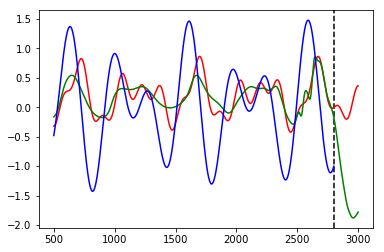

In [24]:
plt.plot(train_range,rhs, c = "r")
plt.axvline(train_range[-1], c = "k", ls = "--")

plt.plot(test_range,test_rhs, c = "r")

# plt.twinx()
plt.plot(train_range, reg.predict(lhs), c = "g")
# plt.plot(train_range,weight @ lhs.T, c = "g")

plt.plot(test_range, reg.predict(test_lhs), c = "g")

plt.plot(train_range, X[train_range], "b")